1、加载和预处理图像


加载内容图像和风格图像，并对它们进行预处理

In [2]:
import torch
import torchvision.transforms as transforms
from PIL import Image

def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size), 
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image).unsqueeze(0)
    return image

# 载入内容图像
content_image = load_image('content.jpg')

# 使用内容图像的尺寸载入风格图像
style_image = load_image('style.jpg', shape=(content_image.shape[-2], content_image.shape[-1]))


2、定义模型和损失函数


使用预训练的 VGG19 网络，并定义内容损失和风格损失。

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = models.vgg19(pretrained=True).features
        self.required_features = ['0', '5', '10', '19', '28']
        self.model = nn.Sequential()
        layer_indices = {str(i): i for i in range(len(self.features))}

        for name, layer in self.features._modules.items():
            self.model.add_module(name, layer)
            if name in self.required_features:
                index = layer_indices[name]
                self.model[index].requires_grad = False

    def forward(self, x):
        features = []
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.required_features:
                features.append(x)
        return features

def gram_matrix(tensor):
    batch_size, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def get_loss(gen_features, org_features, gram_style_features, style_weight, content_weight):
    content_loss = torch.mean((gen_features[1] - org_features[1]) ** 2)

    style_loss = 0
    for gen, style in zip(gen_features, gram_style_features):
        _, d, h, w = gen.size()
        G = gram_matrix(gen)
        A = style
        style_loss += torch.mean((G - A) ** 2) / (d * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

3、训练模型


将定义生成图像并优化它以匹配内容和风格。

In [8]:
import copy
from torch.optim import Adam

def train(content_img, style_img, vgg, num_steps=500, style_weight=1000000, content_weight=1):
    generated_img = content_img.clone().requires_grad_(True)
    optimizer = Adam([generated_img], lr=0.004)
    
    style_features = vgg(style_img)
    content_features = vgg(content_img)
    gram_style_features = [gram_matrix(feature) for feature in style_features]
    
    for step in range(num_steps):
        generated_features = vgg(generated_img)
        total_loss = get_loss(generated_features, content_features, gram_style_features, style_weight, content_weight)
        
        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)  # 添加 retain_graph=True
        optimizer.step()
        
        if step % 50 == 0:
            print(f'Step [{step}/{num_steps}], Loss: {total_loss.item():.4f}')
    
    return generated_img

vgg = VGG().to('cuda')
content_img = content_image.to('cuda')
style_img = style_image.to('cuda')

output = train(content_img, style_img, vgg)


Step [0/500], Loss: 407923744.0000
Step [50/500], Loss: 73338544.0000
Step [100/500], Loss: 43645516.0000
Step [150/500], Loss: 34102548.0000
Step [200/500], Loss: 28699804.0000
Step [250/500], Loss: 24913092.0000
Step [300/500], Loss: 21949300.0000
Step [350/500], Loss: 19485740.0000
Step [400/500], Loss: 17369836.0000
Step [450/500], Loss: 15527045.0000


4、显示结果


将生成的图像转换回图像格式并显示。

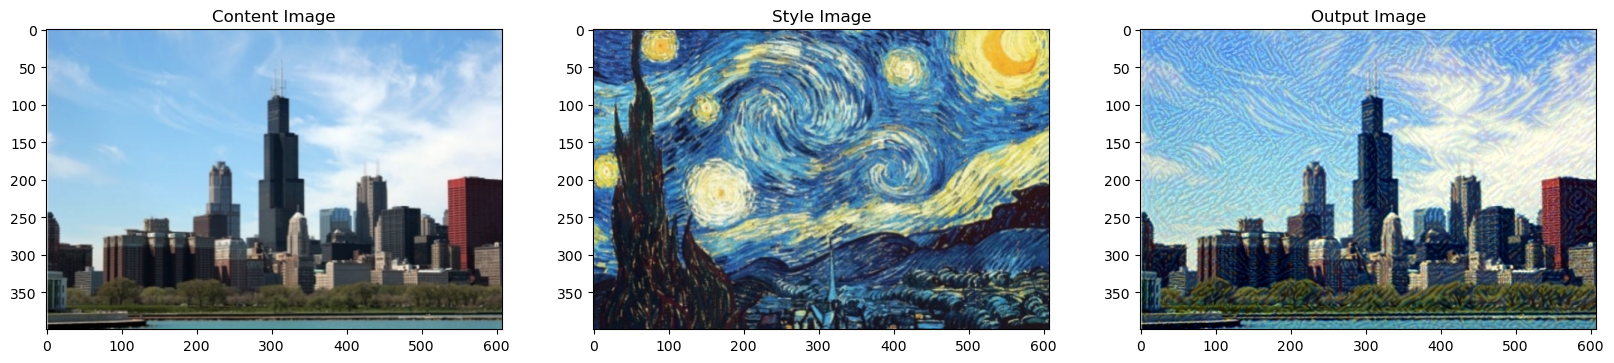

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image
def save_image(tensor, path):
    image = im_convert(tensor)
    image = Image.fromarray((image * 255).astype(np.uint8))
    image.save(path)
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.title('Content Image')
plt.imshow(im_convert(content_image))

plt.subplot(1, 3, 2)
plt.title('Style Image')
plt.imshow(im_convert(style_image))

plt.subplot(1, 3, 3)
plt.title('Output Image')
plt.imshow(im_convert(output))
save_image(output, 'output.jpg')

plt.show()
